# Development of data pipelines from mongodb to ML model

- Removal of matplotlib finanace module (deprecated)
- Base package upgrades for core packages and utilities 
- Usage of raw_data_pipeline folder for development of data pipeline (Scikit-Learn & Tensorflow)
- Usage of in-line markdown cells in-notebook for readability and consistency
- Development groundwork for automation pipeline for automated hourly data scrape, cycling, and training for model through segregated instance or live online-based model
    

In [45]:
# Imports
import pandas as pd
import numpy as np
import requests
import json
from json import loads
import datetime 
import matplotlib.pyplot as plt
import time

# Removal of matplotlib finance module imports (deprecated; implement modern replacement)
from mpl_finance import candlestick_ohlc,candlestick2_ohlc
import cbpro

# Pymongo import (connection to local client DB)
import pymongo
from pymongo import MongoClient

# Preprocessing imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical 

# ML imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding, Flatten
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras.models import model_from_json
from keras import backend as K
from keras import optimizers
from keras.layers import Bidirectional
from keras.layers import TimeDistributed

# Auto Support and Resistance/autoSR() import requirements
from sklearn.cluster import MeanShift, estimate_bandwidth
pd.core.common.is_list_like = pd.api.types.is_list_like
    # Import error for Pandas Datareader, cannot import name "is_list_like"
    # https://github.com/pydata/pandas-datareader/issues/545
    # Workaround for pandas 0.23: https://stackoverflow.com/a/50415484
        # Before pandas_datareader import:
        # pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data, wb

# Intermediate on-disk format for data pipeline from MongoDB/Pandas
import feather
    # Merged PR #43: 
    # https://github.com/timothyyu/gdax-orderbook-ml/pull/43

In [4]:
# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib

# Keras backend import to also check the above
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [5]:
###########################################################################    
# Force/specify number of cores to use for Tensorflow with CPU backend
    # Python GIL (https://wiki.python.org/moin/GlobalInterpreterLock) will force to single core 
    # Thus, explicitly define cores availble
num_cores = 4
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 1})

### Specify that both CPU and GPU devices are available (GPU assumed available):
    # {'CPU' : 1, 'GPU' : 0}
### Force Keras/TF to use CPU backend when GPU present by setting device_count (above) to:
    # {'CPU' : 1, 'GPU' : 0}
    
session = tf.Session(config=config)
K.set_session(session)
###########################################################################

In [6]:
# Verify CPU/GPU availability for tensorflow backend

print("==============================================")
print("Available devices (local):\n")
print(device_lib.list_local_devices())
print("==============================================")
print("Available GPUs:\n")
print(K.tensorflow_backend._get_available_gpus())
print("==============================================")

Available devices (local):

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16179252157632950085
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9212319499
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14014420374150764159
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Available GPUs:

['/job:localhost/replica:0/task:0/device:GPU:0']


In [7]:
# Check Pandas Version
    # 0.23.3 or above required
pd.__version__
    # Merged PR #43, pandas upgraded: 
        # https://github.com/timothyyu/gdax-orderbook-ml/pull/43

'0.23.4'

In [8]:
# Jupyter notebook display variables
%matplotlib inline

In [9]:
# Global variables

# Boolean to drop existing mongo collection/scrape upon scrape() init
    # Default = False
dropFlag = False

# Boolean to set size_delta to l2update values for first update to snapshot
    # Inital value = False
firstUpdate_both = False

# Value to track if feature_creation_inital() was run
    # Inital value = False
inital_feature_run = False

# Import 1 hour of raw data + L2 updates into localized mongodb instance for pipeline development

1. Start new mongodb instance in new Terminal:
`mongod`
2. Copy mongo_raw from raw_data to raw_data_pipeline folder
3. Navigate to raw_data_pipeline folder 
4. Import mongo_raw.json into localized mongo instance:
`mongoimport --db btcusd_db --collection btcusd_collection --file mongo_raw.json`
5. Verify db and collection presence with Terminal instance of mongod and/or MongoDB Compass
    - After mongo_raw.json has been imported, only mongod instance needs to be started for mongoClient connection to be established
    - Only necessary when using functions that require mongoDB connectivity
    

In [10]:
# Connection establishment (MongoDB)
    # Requires db and collection 'btcusd_db' and 'btcusd_collection' to be present on instance

# Establish connection to GDAX public endpoint
public_client = cbpro.PublicClient()

# Mongo database and collection specification:
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client.btcusd_db
btcusd_collection = db.btcusd_collection

In [11]:
#def scrape_start():
    # Needs rewrite - see pull request #44:
        # https://github.com/timothyyu/gdax-orderbook-ml/issues/44

In [12]:
# Function to load and parse data from Mongo into dataframes
def load_parse_feather():
    
    # Collection specification (in database)
    input_data = db.btcusd_collection 
    
    # Create individual dataframes for main response types: snapshot, l2update
    snapshot = pd.DataFrame(list(input_data.find({'type':'snapshot'})))
    l2update = pd.DataFrame(list(input_data.find({'type':'l2update'})))
    
    ### snapshot/orderbook state response load and parse ###
    
    # Extract asks/bid individual column of array of arrays into lists
    snapshot_asks = snapshot[['asks'][0]][0]
    snapshot_bids = snapshot[['bids'][0]][0]
    
    # Convert list (of array of arrays) into dataframe
    snapshot_asks_df =pd.DataFrame(snapshot_asks)
    snapshot_bids_df =pd.DataFrame(snapshot_bids)
    
    # Rename columns to snapshot array format:
        # snapshot array format: [price, size]
            # [side, price, size] format 
        # Ask = sell price, bid = buy price
    snapshot_asks_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_bids_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_asks_df['side'] = "sell"
    snapshot_bids_df['side'] = "buy"
    cols =['side','price','size']
    snapshot_asks_df = snapshot_asks_df[cols]
    snapshot_bids_df = snapshot_bids_df[cols]
    
    ### L2 update response load and parse ###
    
    # Restucture l2update to have [side,price,size] from 'changes' column
    l2update_clean = l2update[['changes','time']]
          
    # Convert changes list of lists -> into array 
    l2_array = np.ravel(l2update_clean['changes']) 
    # Flatten the list and remove outer bracket using a list comprehension:
    flattened = [val for sublist in l2_array for val in sublist]
        # Reference: https://stackoverflow.com/questions/11264684/flatten-list-of-lists?
    # Convert back to dataframe and combine with timestamps from l2update:
    changes_df = pd.DataFrame.from_records(flattened)
    # Add time column back to L2 update dataframe
    l2update_formatted = pd.concat([changes_df,l2update_clean['time']],1)
    # Rename columns for [side, price, size]:
    l2update_formatted.rename({0:"side",1:"price",2:"size"}, axis ='columns',inplace=True)
    
    # Save parsed data to feather format
        # API -> Mongo -> Dataframe -> .feather format
    l2update_formatted.to_feather("raw_data_pipeline/l2update.feather")
    snapshot_asks_df.to_feather("raw_data_pipeline/snapshot_asks.feather")
    snapshot_bids_df.to_feather("raw_data_pipeline/snapshot_bids.feather")

In [13]:
def raw_data_load_feather():
    global request_log_df
    global snapshot_asks_df
    global snapshot_bids_df
    global l2update_df
    
    global l2update_15min_1
    global l2update_15min_2
    global l2update_15min_3
    global l2update_15min_4
  
    # pandas.read_feather(path, nthreads=1)
        # Parameter to specify number of threads when reading to dataframes is available
        # Change nthreads parameter to 2 for laptop,2-4 for remote instance, and 4-6 on development machine (recommended)
            # Thread parameter recommended for l2update_df due to I/O overhead
    snapshot_asks_df = pd.read_feather("raw_data_pipeline/snapshot_asks.feather")
    snapshot_bids_df = pd.read_feather("raw_data_pipeline/snapshot_bids.feather")
    l2update_df = pd.read_feather("raw_data_pipeline/l2update.feather",4)
    request_log_df= pd.read_csv("raw_data_pipeline/request_log.csv")
    

In [14]:
# Instance of mongoDB must be running/available to client machine for load_parse_feather():

# Load and parse data from MongoDB into dataframes:
load_parse_feather()

# If Axis error on rename error, Pandas upgrade required:
    # https://stackoverflow.com/questions/47800034/pandas-dataframe-rename-unexpected-keyword-argument-axis-when-using-mapper/47800303

In [15]:
# Load data from .feather data format into inital dataframes
    # Data from raw_data_pipeline folder
raw_data_load_feather()

In [16]:
request_log_df.head()

,Unnamed: 0,iso,epoch
0,request end,2018-04-24T04:52:17.094Z,1.524546e+09
1,request start,2018-04-24T03:52:17.030Z,1.524542e+09


In [17]:
snapshot_asks_df.head()

,side,price,size
0,sell,9693,0.16111052
1,sell,9693.85,0.05
2,sell,9696.6,0.1
3,sell,9699.24,0.125
4,sell,9699.25,1.02998


In [18]:
snapshot_bids_df.head()

,side,price,size
0,buy,9692.99,9.79874518
1,buy,9692.98,0.00254526
2,buy,9692.95,0.05
3,buy,9692.78,0.01
4,buy,9692.69,9.64811343


In [19]:
# Function stack needs rewrite 
    # Removal of matplotlib finance (deprecated)
    # Removal of invalid pandas functions
    
#def chart_1h_request(request_log_df):
#def autoSR(dataframe):
    # Save generated s/r to dataframe + text file/csv, pull request #33
    # https://github.com/timothyyu/gdax-orderbook-ml/issues/33
#def generate_chart(dataframe):

In [20]:
def chart_1h_request(request_log_df):
    
    global chart_1h_df
    request_start = request_log_df['iso'][1]
    request_end = request_log_df['iso'][0]

    # Request 15 minutes of candlestick (open high low close) data from API
        # start time must be in ISO 8601 format for get_product_historic_rates()
    chart_15m = public_client.get_product_historic_rates('BTC-USD', start = request_start,end = request_end, granularity=60)

    # Convert chart data response into dataframes
    chart_1h_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

    # Reorder columns according to label order required by matplotlib finance package
    chart_1h_df = chart_1h_df[["time","open","high","low","close","volume"]]

    # Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
    chart_1h_df.sort_values(by='time',axis=0, inplace =True)

    #Convert/sort time to datetime object (for matplotlib chart format requirement)
    chart_1h_df['time'] =pd.to_datetime(chart_1h_df['time'],unit='s')
    
    #Save 15m OHLC request chart to disk as .csv
    chart_1h_df.to_csv('raw_data_pipeline/chart_1h_ohlc.csv',index=True)

In [23]:
# Auto support/resistance adapted into function 
    # Using estimate_bandwidth and meanshift() from sklearn.cluster library
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
    # Takes dataframe object with open/high/low/close values 
        # Returns list of auto-generated support and resistance levels for price action
            # Can return as nearest int or actual precise levels if non-int    
def autoSR(dataframe):
    
    global ml_results_modified
    
    #data = chart_15m_df.as_matrix(columns=['close'])
        # .as_matrix future deprecation warning; use .values instead
    data= dataframe['close'].values
    # Reshape array into 2D array 
        # .values does not preserve 2D array; .as_matrix does, but is future deprecated
    data = np.reshape(data, (-1, 2))
    data2 = data
    
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
            # Remove duplicate S/R level values using sets
            ml_set =set(ml_results)
            ml_results = list(ml_set)
            # Sort values before return output 
            ml_results.sort()
            
    # Convert to int and remove duplicates (including duplicates from truncation):    
    # Convert ml_results into sorted int array
    ml_results_modified = np.asarray(ml_results)
    #ml_results_modified = np.trunc(ml_results_modified).astype(int)
    #ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 
    # Remove duplicates from int conversion
    #ml_results_modified_set=set(ml_results_modified)
    #ml_results_modified = list(ml_results_modified)
    #ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort')
    #ml_results_modified
  
    # Save autoSR results to csv
    np.savetxt('raw_data_pipeline/chart_1h_autosr.csv',ml_results_modified ,delimiter=',')
    return ml_results_modified

In [21]:
# Function must be updated to use python 3
def autoSR_alt(dataframe, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    
    Source: https://kite.trade/forum/discussion/1047/a-simple-python-function-to-detect-support-resistance-levels
    """
    from scipy.signal import savgol_filter as smooth
    
    # .as_matrix future deprecation warning; use .values instead
    # ltp = dataframe.as_matrix(columns=['close'])
    ltp = dataframe['close'].values
   
    #Required for x/y array length fix
    ltp = np.ravel(ltp)
    
    #converting n to a nearest even number
    if n%2 != 0:
        n += 1
    
    n_ltp = ltp.shape[0]
    print("Shaped coficient array:",n_ltp)
    print("Cofficients:",len(ltp))
    
    # Smoothing the output curve
    # Ref: 
        # https://github.com/scipy/scipy/blob/master/scipy/signal/_savitzky_golay.py
    ltp_s = smooth(ltp, (n-1), 3) 
    print("Smoothed ltp_s:",ltp_s)
    
    #taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])
    print("ltp_s derivative:",ltp_d)
 
    resistance = []
    support = []
    
    print(n_ltp)
    print(n)
    # Use range instead of xrange; xrange is python 2
    
    for item in ltp_d:
        #print(item)
        first = ltp_d[:(n//2)] #first half
        last = ltp_d[(n//2):] #second half
        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)
        #local maxima detection
        if (r_1 == (n/2)) and (r_2 == (n/2)): 
            print(item)
        
    for i in range(n_ltp - n):
        
        #arr_sl = ltp_d.reshape((1, -1))
        arr_sl = ltp_d[i:(i+n)]
        
        
        first = arr_sl[:(n//2)] #first half
        last = arr_sl[(n//2):] #second half
        
        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        #local maxima detection
        if (r_1 == (n/2)) and (r_2 == (n/2)): 
            resistance.append(ltp[i+((n/2)-1)])

        #local minima detection
        if (s_1 == (n/2)) and (s_2 == (n/2)): 
            support.append(ltp[i+((n/2)-1)])
    return support, resistance

In [22]:
# Function must be updated to use python 3
def autoSR_alt_experimental(dataframe, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    
    Source: https://kite.trade/forum/discussion/1047/a-simple-python-function-to-detect-support-resistance-levels
    """
    from scipy.signal import savgol_filter as smooth
    ltp = dataframe['close'].values
    #Required for x/y array length fix
    ltp = np.ravel(ltp)
    #converting n to a nearest even number
    #if n%2 != 0:
        #n += 1
    
    n_ltp = ltp.shape[0]
    print("Shaped coficient array:",n_ltp)
    print("Cofficients:",len(ltp))
    
    # Smoothing the output curve
    # Ref: 
        # https://github.com/scipy/scipy/blob/master/scipy/signal/_savitzky_golay.py
    ltp_s = smooth(ltp, (n-1), 4) 
    
    ltp_s0 = smooth(ltp, (n-1), 0) 
    ltp_s1 = smooth(ltp, (n-1), 1) 
    ltp_s2 = smooth(ltp, (n-1), 2) 
    ltp_s3 = smooth(ltp, (n-1), 3) 
    ltp_s4 = smooth(ltp, (n-1), 4)
    
    print("=====================================")
    print("Smoothed ltp_s: \n",ltp_s)
    
    #taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])
    
    ltp_d0 = np.zeros(n_ltp)
    ltp_d1 = np.zeros(n_ltp)
    ltp_d2 = np.zeros(n_ltp)
    ltp_d3 = np.zeros(n_ltp)
    ltp_d4 = np.zeros(n_ltp)
    
    ltp_d0[1:] = np.subtract(ltp_s0[1:], ltp_s0[:-1])
    ltp_d1[1:] = np.subtract(ltp_s1[1:], ltp_s1[:-1])
    ltp_d2[1:] = np.subtract(ltp_s2[1:], ltp_s2[:-1])
    ltp_d3[1:] = np.subtract(ltp_s3[1:], ltp_s3[:-1])
    ltp_d4[1:] = np.subtract(ltp_s4[1:], ltp_s4[:-1])
    
    print("=====================================")
    print("ltp_s derivative: \n",ltp_d)
    
    resistance = []
    support = []
    
    #print(n_ltp)
    #print(n)
    
    # Use range instead of xrange; xrange is python 2
    first = ltp_d[:(n//2)] #first half
    last = ltp_d[(n//2):] #second half
    print("=====================================")
    print("first half of ltp_d: \n",first)
    print("last half ltp_d: \n",last)
    print("=====================================")
    r_1 = np.sum(first > 0)
    r_2 = np.sum(last < 0)
    s_1 = np.sum(first < 0)
    s_2 = np.sum(last > 0)
    
    print("r/s derivative values: \n",r_1,r_2,s_1,s_2)
    print("=====================================")
    
    from scipy.signal import argrelextrema
    from scipy.signal import find_peaks
    from scipy.signal import argrelmax
    from scipy.signal import argrelmin
    
    max_ind=argrelextrema(ltp_d,np.greater)
    max_vals = ltp_d[max_ind]
    print("Indices of local maxima: \n",max_ind)
    print("local maxima values: \n",max_vals)
    
    min_ind=argrelextrema(ltp_d,np.less)
    min_vals = ltp_d[min_ind]
    print("Indices of local minima: \n",min_ind)
    print("local minima values: \n",min_vals)
    
    print("argrelmin: \n",argrelmin(ltp_d))
    print("argrelmax: \n",argrelmax(ltp_d))
    
    for item in ltp_d:
        #print(item)
        print(item/2) 
        #print(item//2) 
        #local maxima detection
        if (r_1 == (item//2)) and (r_2 == (item//2)): 
            resistance.append(item)
        #local minima detection
        if (s_1 == (item//2)) and (s_2 == (item//2)): 
            support.append(item)

    return support, resistance

In [24]:
#chart_1h_df.count()

In [32]:
autoSR_alt_experimental(chart_1h_df,len(chart_1h_df))

Shaped coficient array: 60
Cofficients: 60
Smoothed ltp_s: 
 [9179.8766324  9184.79104542 9189.14937195 9192.99037388 9196.35160951
 9199.26943355 9201.77899713 9203.91424779 9205.70792949 9207.19158259
 9208.39554387 9209.34894653 9210.07972018 9210.61459084 9210.97908094
 9211.19750934 9211.29299128 9211.28743846 9211.20155895 9211.05485726
 9210.86563431 9210.65098742 9210.42681034 9210.20779321 9210.00742262
 9209.83798154 9209.71054937 9209.63500192 9209.62001141 9209.67304698
 9209.23596152 9209.40335894 9209.6722734  9210.04555816 9210.52450328
 9211.10883508 9211.79671614 9212.58474532 9213.46795772 9214.43982475
 9215.49225404 9216.61558953 9217.7986114  9219.0285361  9220.29101635
 9221.57014115 9222.84843575 9224.10686167 9225.3248167  9226.4801349
 9227.54908659 9228.50637836 9229.32515308 9229.97698986 9230.43190409
 9230.65834745 9230.62320785 9230.29180948 9229.62791281 9228.59371456]
ltp_s derivative: 
 [ 0.          4.91441302  4.35832653  3.84100193  3.36123563  2.917

C:\Users\tyu-dev\Anaconda3\envs\gdax-orderbook-ml\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


([], [])

In [46]:
autoSR(chart_1h_df)
ml_results_modified

array([9192.  , 9192.01, 9196.99, 9200.01, 9202.2 , 9208.65, 9209.99,
       9210.  , 9210.01, 9214.98, 9214.99, 9219.29, 9219.99, 9220.96,
       9224.96, 9225.  , 9226.3 , 9232.02, 9235.  , 9237.  ])

In [53]:
# MPL finance calls --> replace with stock MPL or use different visualization library

# Function to generate candlestick chart from candlestick data (API request)
    # Calls autoSR() inside function to also plot support/resistance lines
    
def generate_chart(dataframe):

    dataframe = chart_1h_df 
    
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(20, 14))
    
    # Generate chart of past 15 minutes with autogenerated support and resistance levels:
    candlestick2_ohlc(ax,chart_1h_df['open'],chart_1h_df['high'],\
                      chart_1h_df['low'],chart_1h_df['close'],width=2,\
                      colorup='k',colordown='r',alpha=.5)
    
    ax.set_xticklabels(chart_1h_df['time'] ,rotation=30,ha="right")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(17))
        # n + 2 for proper label set at 20,18/20,14 chart size
    plt.yticks(np.arange(int(min(chart_1h_df['low'])-10), max(chart_1h_df['high'])+10, 10))
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    #ax.minorticks_on()
    ax.set_axisbelow(True)
    #fig.set_zorder(0)
    #ax.set_zorder(1)
    ax.tick_params(axis='y', pad=10)
    ax.grid(which='major', linestyle='--', linewidth='0.2', color='b')
    plt.title("15 Min BTC/USD with Support/Resistance Levels")
    
    # call autoSR() to autogenerate support and resistance levels from chart data
    ml_results_modified = autoSR(chart_1h_df)
    
    # Add S/R labels to chart
        # count increment is used for staggering of labels in conjunction with modulus   
    count = 1
    for k in ml_results_modified:
        # Plot each S/R level as horizontal line on chart
        ax.axhline(y=k)
        if count%3 == 0:
            plt.text(y=k,s=k,x=count-5,color='blue',rotation=45,size ='large')\
            .set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        if count%3 == 1:
            plt.text(y=k,s=k,x=count+5,color='blue',rotation=45,size ='large')\
            .set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        if count%3 == 2:
            plt.text(y=k,s=k,x=count+16,color='blue',rotation=45, size ='large')\
            .set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        count = count +1 
    plt.savefig('saved_charts/chart_15m_generated.png')    
    #plt.tight_layout()
    return plt.show()

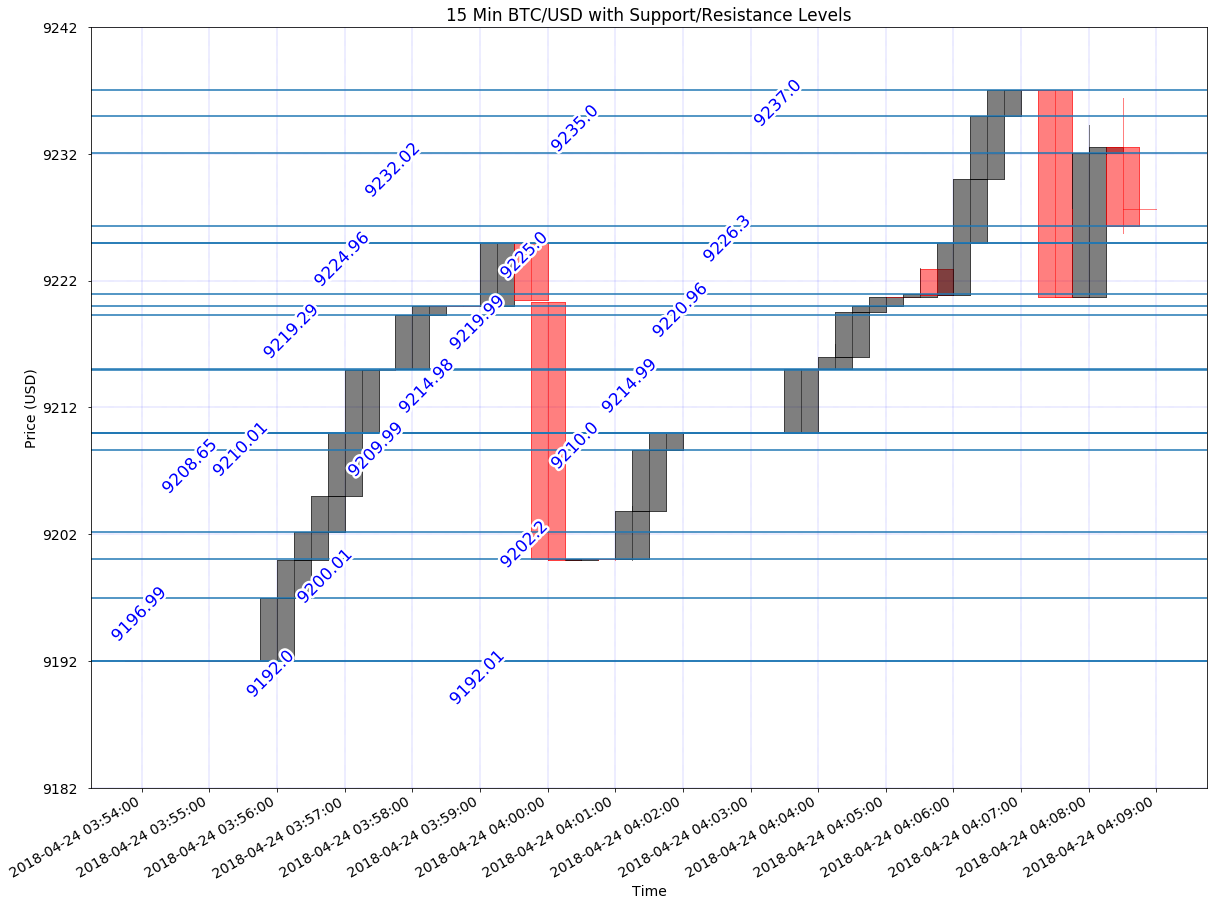

In [55]:
import matplotlib.ticker as ticker
import matplotlib.patheffects as PathEffects
generate_chart(chart_1h_df)

In [35]:
chart_1h_request(request_log_df)

In [36]:
# Pass index_col= 0 to read data from csv 1:1 from saved df --> csv values
test= pd.read_csv("raw_data_pipeline/chart_1h_ohlc.csv",index_col=0 )
test.head()
#chart_1h_df.head()

,time,open,high,low,close,volume
59,2018-04-24 03:53:00,9192.00,9192.01,9192.0,9192.00,4.714037
58,2018-04-24 03:54:00,9192.01,9192.01,9192.0,9192.00,7.134894
57,2018-04-24 03:55:00,9192.01,9192.01,9192.0,9192.00,13.375614
56,2018-04-24 03:56:00,9192.01,9192.01,9192.0,9192.01,2.476776
55,2018-04-24 03:57:00,9192.01,9192.01,9192.0,9192.01,1.367583


In [37]:
# Load results of autoSR from csv
test_arr =np.genfromtxt('raw_data_pipeline/chart_1h_autosr.csv',delimiter=',')
test_arr

array([9192.  , 9192.01, 9196.99, 9200.01, 9202.2 , 9208.65, 9209.99,
       9210.  , 9210.01, 9214.98, 9214.99, 9219.29, 9219.99, 9220.96,
       9224.96, 9225.  , 9226.3 , 9232.02, 9235.  , 9237.  ])

In [38]:
request_log_df.head()

,Unnamed: 0,iso,epoch
0,request end,2018-04-24T04:52:17.094Z,1.524546e+09
1,request start,2018-04-24T03:52:17.030Z,1.524542e+09


In [39]:
chart_1h_df.head()

,time,open,high,low,close,volume
59,2018-04-24 03:53:00,9192.00,9192.01,9192.0,9192.00,4.714037
58,2018-04-24 03:54:00,9192.01,9192.01,9192.0,9192.00,7.134894
57,2018-04-24 03:55:00,9192.01,9192.01,9192.0,9192.00,13.375614
56,2018-04-24 03:56:00,9192.01,9192.01,9192.0,9192.01,2.476776
55,2018-04-24 03:57:00,9192.01,9192.01,9192.0,9192.01,1.367583


In [40]:
chart_1h_df.tail()

,time,open,high,low,close,volume
4,2018-04-24 04:48:00,9220.74,9227.65,9220.73,9220.74,10.831441
3,2018-04-24 04:49:00,9220.74,9234.24,9220.74,9232.02,16.893378
2,2018-04-24 04:50:00,9232.02,9232.50,9232.01,9232.50,3.705115
1,2018-04-24 04:51:00,9232.50,9236.40,9225.75,9226.30,24.274001
0,2018-04-24 04:52:00,9227.62,9227.62,9227.61,9227.62,13.208367


In [41]:
# Plot the above data with autogenerated support and resistance levels for price 
    # Pass dataframe to autoSR() --> create chart + generate and plot auto S/R levels
    # Pass dataframe to autoSR() --> just generate S/R levels and return as array

#autoSR(chart_1h_df), generate_chart(chart_1h_df)

In [42]:
#def feature_creation_inital():
#def l2update_1hr_split(l2update_df):
#def snapshot_join(snapshot_asks_df,snapshot_bids_df):
#def apply_l2_update(snapshot_both_df,l2update_15min):

#def chart_15m_request(request_log_df):
    # Not respecting time format - pull req #9
        #https://github.com/timothyyu/gdax-orderbook-ml/issues/9
    # Requires rewrite - strip MPL dependecies
    # Replace with plotly, pure matplotlib, or modern alternative

In [ ]:
### ML-specific PR: ##
    
# train_test_split() does not work with shaped data (x features/y target)
    #https://github.com/timothyyu/gdax-orderbook-ml/issues/22

# scrape abstraction for input batch size requirements 
    # https://github.com/timothyyu/gdax-orderbook-ml/issues/26

In [ ]:
#look into gdax-python-api (async) replacement for api library
    #https://github.com/timothyyu/gdax-orderbook-ml/issues/21

In [ ]:
# Mockup design of predicted vs actual 
    #https://github.com/timothyyu/gdax-orderbook-ml/issues/18